In [25]:
# load env ------------------------------------------------------------------------
import functools
import os
from unittest import skip
import uuid
import database.chat_history
import database.customer
import utils
import re

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(False)
set_debug(False)

from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    HumanMessage,
)
from langchain_core.tools.structured import StructuredTool
from langgraph.graph import END, StateGraph, START
from agents import(
    AgentState,
    agent_names,
    agent_nodes,
    service_node_build
)
from tools import get_tools_output, all_tools, set_current_user_id
from functools import partial
from langgraph.checkpoint.memory import MemorySaver
import database
## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal, Optional, TypedDict


class BotConfig(TypedDict):
    keep_chat_history:Optional[bool]
    return_reference:Optional[bool]
    verbose:Optional[bool]
    recursion_limit:Optional[int]
    thread_id: Optional[uuid.UUID]
    

class AgentBot:
    tool_node:ToolNode
    agent_names:list[str]
    agent_nodes:dict[str, dict[str, partial]]
    workflow: StateGraph
    config:BotConfig = BotConfig({
        'keep_chat_history': False,
        'return_reference': False,
        'verbose': False,
        'recursion_limit': 20,
        'thread_id': uuid.uuid4(),
        'socketio_instance':None
    })
    def __init__(self, **config:BotConfig):
        self.tool_node = ToolNode(all_tools)
        self.agent_names = agent_names
        self.agent_nodes = agent_nodes
        self.config.update(**config)
        self.workflow = self.create_workflow()
                
        
    def __with_debug_command(self, func):
        def __convert_input_value(input_config_value: str):
            # Check if input is a boolean
            if input_config_value.lower() == "false":
                return False
            elif input_config_value.lower() == "true":
                return True
            
            # Check if input is an integer
            try:
                int_value = int(input_config_value)
                return int_value
            except ValueError:
                pass

            # Check if input is a float
            try:
                float_value = float(input_config_value)
                return float_value
            except ValueError:
                pass

            # If none of the above, return the original string
            return input_config_value
        
        @functools.wraps(func)  # Preserve the original function's metadata
        def wrapper(self, *args, **kwargs):
            user_input = args[0]
            user_id = kwargs['user_id']
            
            if not re.search(r"//", user_input):
                return func(*args, **kwargs)
                
            if re.search(r"//reset", user_input):
                database.customer.delete(user_id="test")
                database.chat_history.delete(user_id=user_id)
                database.customer.update({
                    "name":"สมชาย สายชม",
                },user_id=user_id)
                return f"user data and chat history have been reset."
            
            if re.search(r"//delete chat history", user_input):
                o = database.chat_history.delete(user_id=user_id)
                return f"chat history of this user have been deleted."
            
            if re.search(r"//get chat history", user_input):
                history = database.chat_history.get_str(user_id=user_id, chat_history=[])
                nl = "\n"
                return f"chat history: \n{nl.join(history)}"
                
            if re.search(r"//get user data", user_input):
                user_data = database.customer.get(user_id=user_id)
                return f"user data: \n{user_data}"
                
            if re.search(r"//debug", user_input):
                user_input = re.sub(r"//debug", '', user_input)
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    return f"error: {e}"
            
            for configkey in self.config.keys():
                if re.search(r"//{configkey} ?= ?".format(configkey=configkey), user_input):
                    input_config_value = re.sub(r"//{configkey} ?= ?".format(configkey=configkey), '', user_input)
                    self.config[configkey] = __convert_input_value(input_config_value)
                    return f"set config: {configkey} to {input_config_value}"
            
        return wrapper
    
    
    def draw_graph(self):
        from IPython.display import Image, display
        graph = self.workflow.compile()
        return display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    
    
    def create_workflow(self):
        def router(state) -> Literal["call_tool", "continue", "__end__"]:
            # This is the router
            messages = state["messages"]
            last_message = messages[-1]
            if "FINALANSWER" in last_message.content:
                return "__end__"
            if last_message.tool_calls:
                # The previous agent is invoking a tool
                return "call_tool"
            else:
                return "continue"
        
        workflow = StateGraph(AgentState)

        llm = ChatOpenAI(
            model="gpt-4o-mini-2024-07-18", 
            temperature=0, 
            top_p=0, 
        )
        
        # add agent nodes
        self.agent_nodes["service"] = functools.partial(self.agent_nodes["service"], llm=llm)
        workflow.add_node("service", self.agent_nodes["service"])
            
        workflow.add_node("call_tool", self.tool_node)

        workflow.add_conditional_edges(
            "service",
            router,
            {
                "call_tool": "call_tool",
                "__end__": END,
                "continue": END, 
                }
        )

        workflow.add_conditional_edges(
            "call_tool",
            # Each agent node updates the 'sender' field
            # the tool calling node does not, meaning
            # this edge will route back to the original agent
            # who invoked the tool
            lambda x: x["sender"],
            {name:name for name in agent_names},
        )

        workflow.add_edge(START, "service")
        
        return workflow


    def submit_user_message(
        self,
        user_input:str, 
        user_id:str="test", 
        ) -> str:
        # set_current_user_id(user_id)
        chat_history = database.chat_history.get(user_id=user_id) if self.config['keep_chat_history'] else []
        chat_history = chat_history[-8:]
        
        # memory only keep chat history only along agents.
        # internal_level_memory = MemorySaver()
        # graph = workflow.compile(checkpointer=internal_level_memory)
        
        graph = self.workflow.compile()

        events = graph.stream(
            {
                "messages": [
                    HumanMessage(
                        user_input
                    )
                ],
                "chat_history": chat_history
            },
            # Maximum number of steps to take in the graph
            {"recursion_limit": self.config['recursion_limit'], "thread_id":self.config['thread_id']},
        )
        
        for e in events:
            a = list(e.items())[0]
            if self.config['verbose']:
                a[1]['messages'][0].pretty_print()
        
        response = a[1]
        
        response = response["messages"][0].content
        response = utils.format_bot_response(response, markdown=True)
        
        if self.config['keep_chat_history']:
            chat_history = database.chat_history.insert(bot_message=response, human_message=user_input, user_id=user_id)
        
        if self.config['return_reference']:
            return response, get_tools_output()
        else:
            return response
        
        
    async def submit_user_message_async(
        self,
        user_input:str, 
        user_id:str="test", 
        ) -> str:
        # set_current_user_id(user_id)
        chat_history = database.chat_history.get(user_id=user_id) if self.config['keep_chat_history'] else []
        chat_history = chat_history[-8:]
        
        # memory only keep chat history only along agents.
        # internal_level_memory = MemorySaver()
        # graph = workflow.compile(checkpointer=internal_level_memory)
        
        graph = self.workflow.compile()

        events = graph.astream(
            {
                "messages": [
                    HumanMessage(
                        user_input
                    )
                ],
                "chat_history": chat_history
            },
            # Maximum number of steps to take in the graph
            {"recursion_limit": self.config['recursion_limit'], "thread_id":self.config['thread_id']},
            stream_mode="values"
        )
        
        async for e in events:
            if self.config['verbose']: 
                e["messages"][-1].pretty_print()
            response = e["messages"][-1]
        
        response = response.content
        response = utils.format_bot_response(response, markdown=True)
        
        if self.config['keep_chat_history']:
            chat_history = database.chat_history.insert(bot_message=response, human_message=user_input, user_id=user_id)
        
        if self.config['return_reference']:
            return response, get_tools_output()
        else:
            return response
      
            
    def submit_user_message_with_debug_command(self, *args, **kwargs) -> str:
        return self.__with_debug_command(self.submit_user_message)(self, *args, **kwargs)

In [26]:
Bot = AgentBot(keep_chat_history=True, verbose=True)

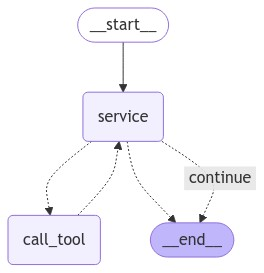

In [27]:
Bot.draw_graph()

In [28]:
Bot.submit_user_message_with_debug_command("//reset", user_id="test")
Bot.submit_user_message_with_debug_command("//get chat history", user_id="test")

'chat history: \n'

In [33]:
Bot.submit_user_message_with_debug_command(r"ไม่มี", user_id="test")

================================== Ai Message ==================================
Name: service

เข้าใจค่ะคุณสมชาย ขอบคุณที่ให้ข้อมูลนะคะ 

ตอนนี้เรายังไม่มีข้อมูลเกี่ยวกับยอดหนี้ปัจจุบันของคุณในระบบ ถ้ามี คุณสามารถบอกยอดหนี้ล่าสุดของคุณได้ไหมคะ? หรือถ้าคุณไม่มีหนี้ก็สามารถบอกได้ค่ะ


'เข้าใจค่ะคุณสมชาย ขอบคุณที่ให้ข้อมูลนะคะ \n\nตอนนี้เรายังไม่มีข้อมูลเกี่ยวกับยอดหนี้ปัจจุบันของคุณในระบบ ถ้ามี คุณสามารถบอกยอดหนี้ล่าสุดของคุณได้ไหมคะ? หรือถ้าคุณไม่มีหนี้ก็สามารถบอกได้ค่ะ'

In [30]:
Bot.submit_user_message_with_debug_command("//get user data", user_id="test")

"user data: \n{'_id': ObjectId('66fe3f50afe3352ed7281e02'), 'user_id': 'test', 'name': 'สมชาย สายชม'}"